# Train, test, export model for Electricty monitor IDS 

Datasets is from personal usage documentation
<br> <br>
Clustered with unsupervised algorithm - Isolation Foreset
<br>
Feature classifying/learning with supervised algorithm - Random Forest

## Config

### Import

In [118]:
# Import necessary libraries
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime
import joblib

from tabulate import tabulate

from sqlalchemy import create_engine, Column, Integer, Float, String, DateTime
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, declarative_base

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, make_scorer, accuracy_score, precision_score, f1_score
from sklearn.utils import resample  
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.svm import OneClassSVM
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

### database config

In [96]:
# Configure database connection
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': '',
    'database': 'db_esp32'
}

In [97]:
# Create engine and session
engine = create_engine('mysql+mysqlconnector://root:@localhost/db_esp32')
Session = sessionmaker(bind=engine)
session = Session()

# Create the Base class
Base = declarative_base()

# Define the ElectricityMonitor class
class ElectricityMonitor(Base):
    __tablename__ = 'electricity_monitor'  # Use your actual table name here
    data_id = Column(Integer, primary_key=True)
    device_id = Column(String(255))
    voltage = Column(Float)
    current = Column(Float)
    power = Column(Float)
    energy = Column(Float)
    frequency = Column(Float)
    power_factor = Column(Float)
    created_at = Column(DateTime)

In [98]:
# Fetch data from the database with only power > 0 and order by created_at in descending order
def fetch_data():
    query = session.query(ElectricityMonitor).where(ElectricityMonitor.power > 0.5).order_by(ElectricityMonitor.created_at.desc())
    df = pd.read_sql(query.statement, query.session.bind)
    return df

def get_deviceId():
    query = session.query(ElectricityMonitor.device_id).distinct()
    device_ids = pd.read_sql(query.statement, query.session.bind)
    return device_ids

df = fetch_data()
device_ids = get_deviceId()

print(df.count())

data_id         31186
device_id       31186
voltage         31186
current         31186
power           31186
energy          31186
frequency       31186
power_factor    31186
created_at      31186
dtype: int64


## Pre-processing

### Load the datasets

In [99]:
print('Count: \n', df.count())
print('\ndatasets: \n', df.head())
print('\n')
print('device_ids: \n', device_ids)

Count: 
 data_id         31186
device_id       31186
voltage         31186
current         31186
power           31186
energy          31186
frequency       31186
power_factor    31186
created_at      31186
dtype: int64

datasets: 
    data_id          device_id  voltage  current  power  energy  frequency  \
0   193867  D4:8A:FC:60:47:60    198.4      0.0    0.9   1.258       49.9   
1   193866  D4:8A:FC:60:47:60    199.0      0.0    0.8   1.258       50.0   
2   193865  D4:8A:FC:60:47:60    200.3      0.0    1.0   1.258       49.9   
3   193864  D4:8A:FC:60:47:60    197.1      0.0    0.8   1.258       49.9   
4   193863  D4:8A:FC:60:47:60    194.9      0.0    0.9   1.258       49.9   

   power_factor          created_at  
0           1.0 2024-07-24 14:20:48  
1           1.0 2024-07-24 14:20:43  
2           1.0 2024-07-24 14:20:38  
3           1.0 2024-07-24 14:20:33  
4           1.0 2024-07-24 14:20:28  


device_ids: 
            device_id
0  D4:8A:FC:60:47:60


#### Handling missing values

In [100]:
print("before:\n\n", df.isnull().sum())
# Fill missing values with median
df['voltage'].fillna(df['voltage'].median())

# Fill device_id with the latest id
latest_id = device_ids['device_id'].iloc[-1]
df['device_id'].fillna(latest_id)

# Fill created_at with current date and time
df['created_at'].fillna(pd.to_datetime('now'))

print("\n\nafter:\n", df.isnull().sum())

before:

 data_id         0
device_id       0
voltage         0
current         0
power           0
energy          0
frequency       0
power_factor    0
created_at      0
dtype: int64


after:
 data_id         0
device_id       0
voltage         0
current         0
power           0
energy          0
frequency       0
power_factor    0
created_at      0
dtype: int64


## Model Training

### Split dataset for training and testing

In [101]:
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)

print(train_df.count())

data_id         20894
device_id       20894
voltage         20894
current         20894
power           20894
energy          20894
frequency       20894
power_factor    20894
created_at      20894
dtype: int64


In [102]:
# Inspect the distribution of the power feature
print("Power Distribution in Training Data:")
print(train_df['power'].describe())

Power Distribution in Training Data:
count    20894.000000
mean        15.464990
std         17.399168
min          0.600000
25%          6.900000
50%         16.300000
75%         17.400000
max       1000.100000
Name: power, dtype: float64


### Unsupervised Learning - Isolation Forest

### Train and predict 

In [103]:
def train_if():
    for device_id in device_ids['device_id']:
        features = ['voltage', 'current', 'power', 'energy', 'frequency', 'power_factor']
        # Train model
        if_model = IsolationForest(contamination=0.1, random_state=42)
        if_model.fit(train_df[train_df['device_id'] == device_id][features])

        # Predict Label
        df.loc[df['device_id'] == device_id, 'if_label'] = if_model.predict(df[df['device_id'] == device_id][features])
        
        # Explicitly cast the 'if_label' column to string type right after prediction
        df['if_label'] = df['if_label'].astype(str)
        df.loc[df['device_id'] == device_id, 'if_label'] = np.where(df.loc[df['device_id'] == device_id, 'if_label'] == '1.0', 'normal', 'anomaly')

        # print(df.head())
        print(df.value_counts('if_label'))
        # filename = f'if_model_{device_id.replace(":", "-")}.pkl'
        # joblib.dump(if_model, filename)
        
train_if()

if_label
normal     28086
anomaly     3100
Name: count, dtype: int64


### Show results for rows that have normal label

In [104]:
for device_id in device_ids['device_id']:
    print(df[df['device_id'] == device_id].value_counts('if_label'))


if_label
normal     28086
anomaly     3100
Name: count, dtype: int64


In [105]:
# testing apakah power di atas 20 watt ada yang normal
for device_id in device_ids['device_id']:
    print(df[(df['power'] > 20) & (df['device_id'] == device_id) & (df['if_label'] != 'anomaly')])



       data_id          device_id  voltage   current  power  energy  \
984     192880  D4:8A:FC:60:47:60    200.6  0.163000   20.8   1.246   
985     192879  D4:8A:FC:60:47:60    200.0  0.160000   20.6   1.246   
997     192866  D4:8A:FC:60:47:60    199.7  0.159000   20.4   1.245   
998     192865  D4:8A:FC:60:47:60    199.6  0.161000   20.5   1.245   
999     192864  D4:8A:FC:60:47:60    200.7  0.158000   20.3   1.245   
...        ...                ...      ...       ...    ...     ...   
31156     8188  D4:8A:FC:60:47:60    210.5  0.162001   20.1   1.033   
31157     8187  D4:8A:FC:60:47:60    209.3  0.163000   20.1   1.033   
31158     8186  D4:8A:FC:60:47:60    209.2  0.163000   20.1   1.033   
31161     8183  D4:8A:FC:60:47:60    209.9  0.162001   20.1   1.033   
31163     8181  D4:8A:FC:60:47:60    210.2  0.162001   20.1   1.033   

       frequency  power_factor          created_at if_label  
984         50.0          0.64 2024-07-24 12:57:06   normal  
985         50.0       

### Show results for rows that have anomaly label

In [106]:
# testing apakah power di atas 17 di bawah 20 watt ada yang anomaly
print(df[(df['if_label'] != 'normal') & (df['power'] > 17) & (df['power'] < 20)].head(10))


       data_id          device_id  voltage  current  power  energy  frequency  \
8059    167824  D4:8A:FC:60:47:60    212.4    0.170   19.0   1.074       49.9   
8065    167818  D4:8A:FC:60:47:60    212.1    0.171   19.3   1.074       49.9   
8066    167817  D4:8A:FC:60:47:60    212.2    0.171   19.3   1.074       49.9   
8067    167816  D4:8A:FC:60:47:60    213.9    0.171   19.5   1.074       49.9   
8068    167815  D4:8A:FC:60:47:60    214.1    0.171   19.6   1.074       49.9   
8069    167814  D4:8A:FC:60:47:60    214.2    0.173   19.6   1.074       49.9   
25554    59065  D4:8A:FC:60:47:60    192.8    0.169   19.2   0.075       49.9   
29986    27778  D4:8A:FC:60:47:60    192.3    0.174   19.9   1.311       49.9   

       power_factor          created_at if_label  
8059           0.53 2024-07-17 10:37:16  anomaly  
8065           0.53 2024-07-17 10:36:46  anomaly  
8066           0.53 2024-07-17 10:36:41  anomaly  
8067           0.53 2024-07-17 10:36:36  anomaly  
8068           

## Supervised Learning - Random Forest

voltage: 0.09418679954844075
current: 0.25871624983165964
power: 0.24000587735322
energy: 0.05408079975461127
frequency: 0.0694685098621992
power_factor: 0.2835417636498691


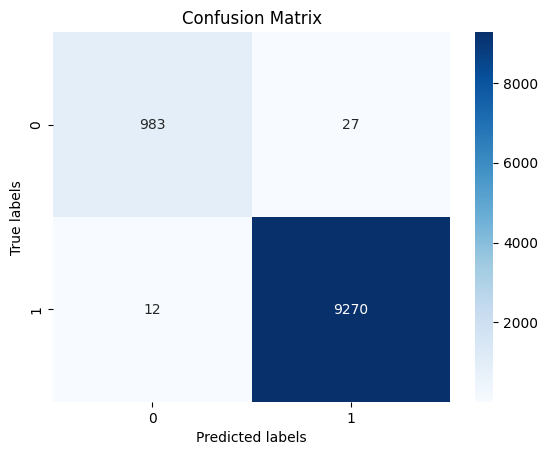

╒══════════╤════════════╤════════════╤═════════════╤══════════╕
│ Metric   │   Accuracy │   F1 Score │   Precision │   Recall │
╞══════════╪════════════╪════════════╪═════════════╪══════════╡
│ Value    │   0.996211 │   0.996198 │    0.996197 │ 0.996211 │
╘══════════╧════════════╧════════════╧═════════════╧══════════╛


In [119]:
import tabulate as tabulate
def train_rf():
    for device_id in device_ids['device_id']:
        features = ['voltage', 'current', 'power', 'energy', 'frequency', 'power_factor']
        X = df[df['device_id'] == device_id][features]
        y = df[df['device_id'] == device_id]['if_label']
        
        # Ensure there is data to train on
        if not X.empty and not y.empty:
            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
            # Splitting the dataset
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

            # Training a Random Forest Classifier
            rf_model.fit(X_train, y_train)

            # Getting feature importances
            feature_importances = rf_model.feature_importances_

            # Printing feature importances
            for feature, importance in zip(X.columns, feature_importances):
                print(f"{feature}: {importance}")

            # Make predictions on the test set
            y_pred = rf_model.predict(X_test)

            # Generate the confusion matrix
            conf_matrix = confusion_matrix(y_test, y_pred)

            # Visualize the confusion matrix (Optional)
            sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
            plt.xlabel('Predicted labels')
            plt.ylabel('True labels')
            plt.title('Confusion Matrix')
            plt.show()
            
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            table = [['Metric', 'Value'],
                ['Accuracy', accuracy],
                ['F1 Score', f1],
                ['Precision', precision],
                ['Recall', recall]]
            # Transpose the table
            transposed_table = list(zip(*table))
            # Print the transposed table
            print(tabulate.tabulate(transposed_table, headers='firstrow', tablefmt='fancy_grid'))
            
            # filename = f'rf_model_{device_id.replace(":", "-")}.pkl'
            # joblib.dump(rf_model, filename)
        else:
            print(f"No data available for device {device_id}, skipping...")

train_rf()